## Estimation of Obesity Levels Based On Eating Habits and Physical Condition

In [673]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)

Ustawiamy globalnie opcję `set_output` ze Scikit-learn'a, aby transformowane dane były typu
`pd.DataFrame`, zamiast `np.ndarray`.

In [674]:
import sklearn

sklearn.set_config(transform_output="pandas")

### Przewidywanie Obesity Levels

Wykorzystamy zbiór danych [Estimation of Obesity Levels Based On Eating Habits and Physical
Condition](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition),
w którym zadaniem jest przewidywanie poziomu otyłości na podstawie informacji dotyczących nawyków
żywieniowych oraz kondycji fizycznej. Zbiór danych został pierwotnie zaprezentowany w pracy [Obesity
Level Estimation Software based on Decision Trees](https://thescipub.com/pdf/jcssp.2019.67.77.pdf),
której celem była przede wszystkim identyfikacja czynników wpływających na rozwój otyłości oraz na
możliwości przewidywania jej wystąpienia na ich podstawie.

Zbiór danych zawiera łącznie 2111 rekordów, z których każdy opisany jest za pomocą 16 cech
(predyktorów) oraz zmiennej objaśnianej (obesity level), która przyjmuje jedną z siedmiu
wartości:

* Insufficient Weight, 
* Normal Weight, 
* Overweight Level I, 
* Overweight Level II, 
* Obesity Type I, 
* Obesity Type II, 
* Obesity Type III.

Mamy tu zatem do czynienia z problemem przewidywania zmiennej dyskretnej. Można go rozwiązywać jako
klasyczne zadanie klasyfikacji wieloklasowej. Ze względu na naturalny porządek między klasami,
istnieje jednak również możliwość potraktowania go jako problemu regresji porządkowej. W dalszej
części dokonano porównania obu podejść.

In [675]:
from ucimlrepo import fetch_ucirepo

dataset_obesity = fetch_ucirepo(id=544)
df = pd.concat([dataset_obesity.data.features, dataset_obesity.data.targets], axis="columns")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [676]:
dataset_obesity.variables

,name,role,type,demographic,description,units,missing_values
0,Gender,Feature,Categorical,Gender,None,None,no
1,Age,Feature,Continuous,Age,None,None,no
2,Height,Feature,Continuous,None,None,None,no
3,Weight,Feature,Continuous,None,None,None,no
4,family_history_with_overweight,Feature,Binary,None,Has a family member suffered or suffers from o...,None,no
5,FAVC,Feature,Binary,None,Do you eat high caloric food frequently?,None,no
6,FCVC,Feature,Integer,None,Do you usually eat vegetables in your meals?,None,no
7,NCP,Feature,Continuous,None,How many main meals do you have daily?,None,no
8,CAEC,Feature,Categorical,None,Do you eat any food between meals?,None,no
9,SMOKE,Feature,Binary,None,Do you smoke?,None,no


In [677]:
df.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

### Eksploracja danych, czyszczenie danych, analiza cech

Na początku sprawdźmy, czy mamy jakieś brakujące wartości i ile ich jest. Ten etap jest przydatny
np. do usunięcia predyktora, który ma zbyt wiele wartości brakujących, aby być użytecznym.

In [678]:
df.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

Żadna z kolumn nie zawiera wartości brakujących, więc imputacja danych nie będzie potrzebna.

Zobaczmy teraz, jak wygląda rozkład klas.

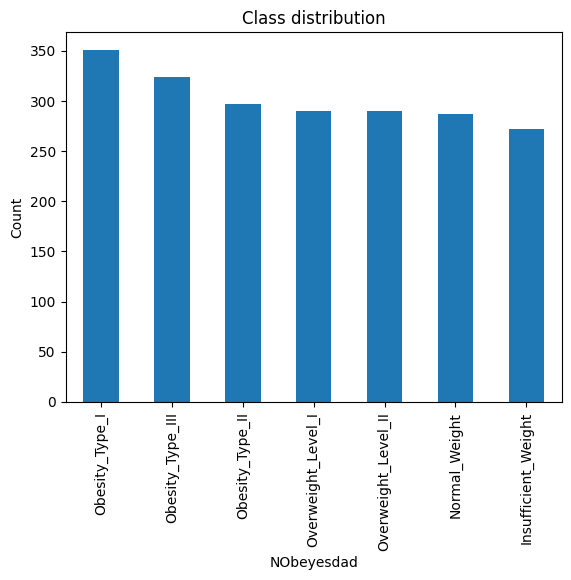

In [679]:
df["NObeyesdad"].value_counts().plot.bar(ylabel="Count", title="Class distribution");

Klasy są względnie zbalansowane, co wynika z faktu, iż część obserwacji w zbiorze danych zostało
wygenerowanych syntetycznie. Dla nas jest to dobra wiadomość, bo silne niezbalansowanie wprowadza
pewne utrudnienia.

W dalszej kolejności zakodujemy zmienne kategoryczne uporządkowane (categorical ordinal) CALC i CAEC
z tekstowych na kolejne liczby całkowite. Dodatkowo zmienimy typ danych kategorycznych z `object` na
`category`.

In [680]:
df = df.replace(
    {
        "CALC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
        "CAEC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
    }
)
df = df.astype({col: "category" for col in df.select_dtypes(include="object").columns})

Dokonamy również inżynierii cech, dodając do zbioru danych predyktor `BMI = Weight / Height**2`.

In [681]:
df["BMI"] = df["Weight"] / df["Height"] ** 2

Wyodrębnijmy od razu zmienne numeryczne i kategoryczne, ponieważ będą one wymagać osobnego
przetwarzania.

In [682]:
cat_features = df.drop(columns=["NObeyesdad"]).select_dtypes(include="category").columns
num_features = df.drop(columns=["NObeyesdad"]).select_dtypes(exclude="category").columns

Przyjrzyjmy się teraz rozkładom zmiennych numerycznych i kategorycznych. Wykorzystamy tutaj bardzo
wygodny interfejs bibliotek Pandas i Seaborn.

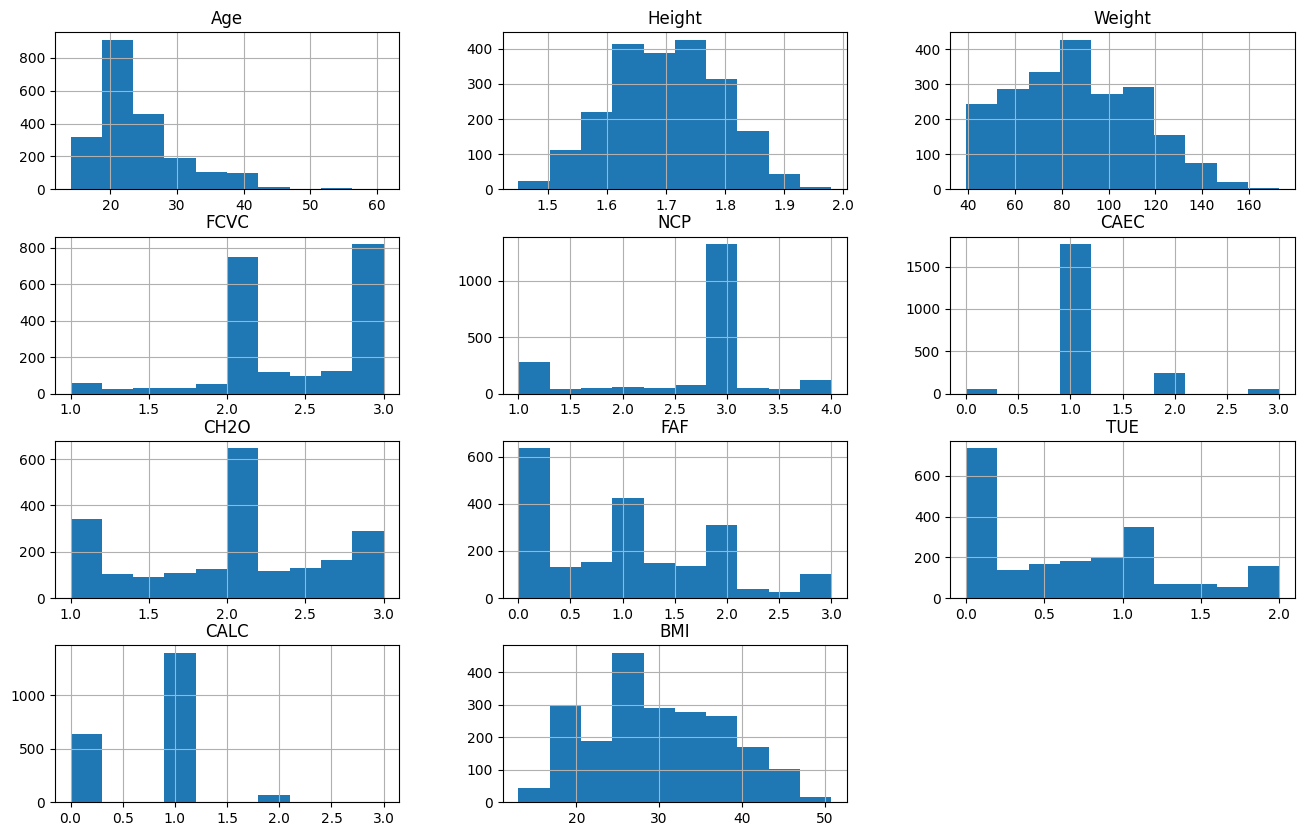

In [683]:
df.hist(figsize=(16, 10));

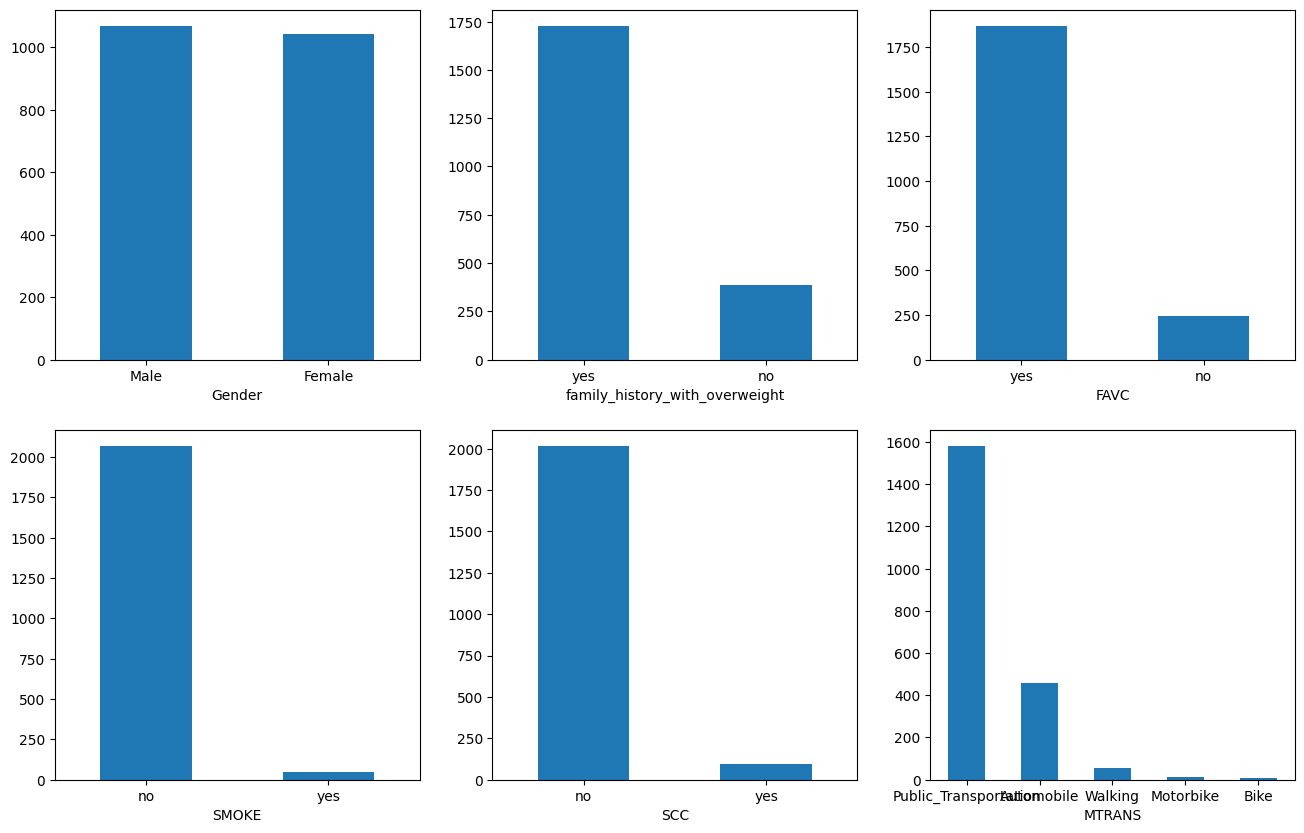

In [684]:
fig, axes = plt.subplots(len(cat_features) // 3, 3, figsize=(16, 10))
for ax, col in zip(axes.flat, cat_features):
    df.loc[:, col].value_counts().plot(kind="bar", ax=ax, rot=0)

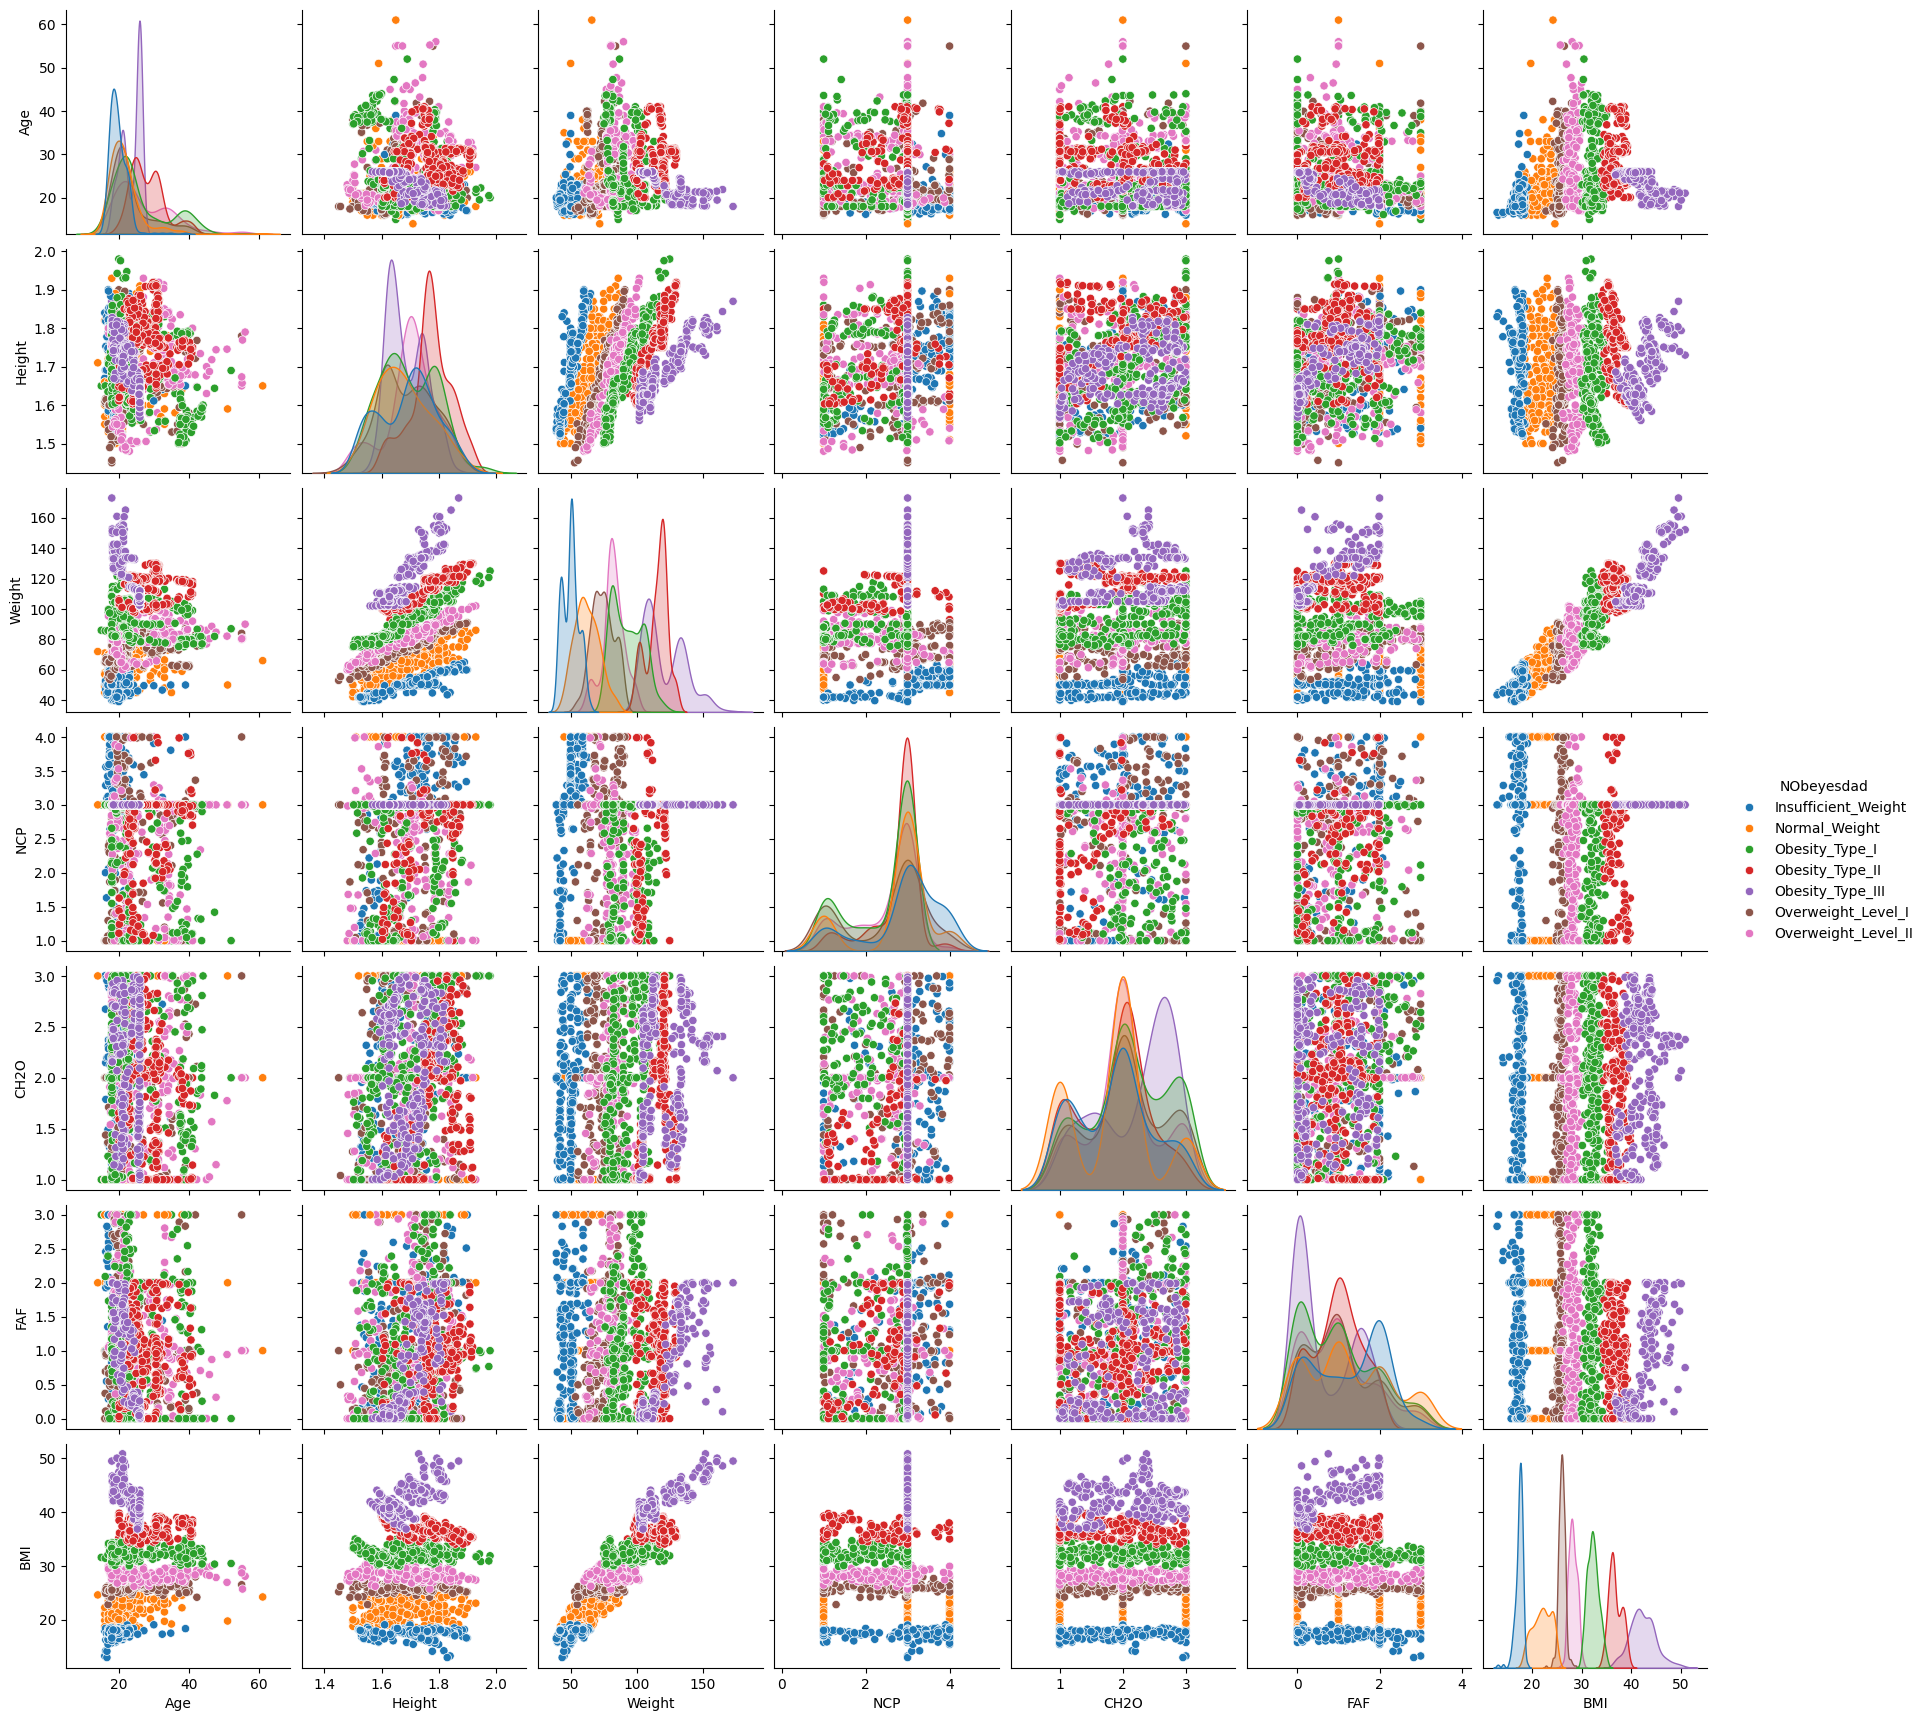

In [685]:
ord_features = ["TUE", "FCVC", "CAEC", "CALC"]
sns.pairplot(data=df.drop(columns=ord_features), hue="NObeyesdad");

Rozkłady są w większości dość skośne i wielomodalne. Wielomodalność jest zapewne artefaktem
związanym z syntetyczną generacją części próbek za pomocą SMOTE, które oryginalnie były wartościami
porządkowymi. Dodatkowo widzimy całkiem dobrą separację klas na płaszczyźnie wyznaczonej przez
predyktory Height i Weight. Nie ma również widocznych outlierów, które należałoby usunąć.

Sprawdzimy jeszcze potencjalne korelacje między cechami. W przypadku modeli liniowych mocno
skorelowane ze sobą cechy będą powodować problemy, dlatego takich korelacji należy się wcześniej
pozbyć.

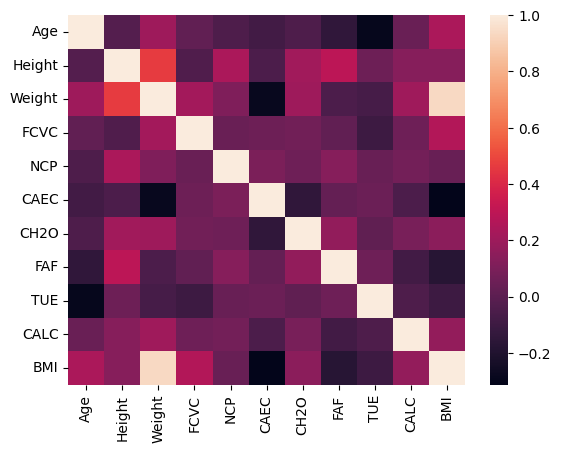

In [686]:
sns.heatmap(df[num_features].corr());

Jak widzimy nie mamy tutaj wielu mocnych korelacji, rzędu 0.8 lub więcej. Jedyną występującą
korelacją jest ta pomiędzy BMI i Weight.

Na tym etapie mamy już zbiór danych, który nie zawiera wartości brakujących, outlierów,
skorelowanych lub niepotrzebnych cech. Możemy zatem przejść do wyboru modeli służących do predykcji
zmiennej objaśnianej na podstawie cech. Do porównania wybrano następujące modele:

* wieloklasowa regresja logistyczna,
* drzewa decyzyjne,
* lasy losowe,
* Gradient Boosted Decision Trees,
* model logitowej regresji porządkowej.

Pominięto tutaj w szczególności model kNN, gdyż wymagałby on wspólnych, semantycznie sensownych
osadzeń wektorów cech do poprawnego użycia.

Od razu dokonamy podziału na zbiór treningowy i testowy, które wykorzystamy do oceny efektywności
modeli. Jako że nasz zbiór jest dość mały, to podział będzie 70%-30%.

In [687]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["NObeyesdad"])
y = df["NObeyesdad"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

Utworzymy również funkcję pomocniczą do ewaluacji modeli.

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score


def evaluate(clf, X_train, X_test, y_train, y_test):
    print("-" * 60)
    print(f"Train accuracy {accuracy_score(y_train, clf.predict(X_train)):.2%}")
    print(f"Test  accuracy {accuracy_score(y_test, clf.predict(X_test)):.2%}")
    print("-" * 60)
    print(f"Train macro-F1 {f1_score(y_train, clf.predict(X_train), average='macro'):.4f}")
    print(f"Test  macro-F1 {f1_score(y_test, clf.predict(X_test), average='macro'):.4f}")
    print("-" * 60)

    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation="vertical")
    plt.show()

### Wieloklasowa regresja logistyczna

Jako pierwszy model baseline'owy spróbujemy wykorzystać wieloklasową regresję logistyczną, tj.
potraktujemy problem jako zadanie klasyfikacji i dopasujemy model postaci

$$
    t(x) \sim \text{Cat}(\text{softmax}(Wx))\,.
$$

Wykorzystamy do tego celu bardzo wydają implementację z biblioteki Scikit-learn, która natywnie
wspiera tuning stałej regularyzującej za pomocą walidacji krzyżowej. Wcześniej musimy oczywiście
odpowiednio przeprocesować dane wejściowe -- przeskalować zmienne numeryczne, aby miały ten sam
zakres wartości oraz zakodować zmienne kategoryczne w postaci one-hot, pamiętając o dummy-variable
trap.

In [689]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

clf_lr = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("cat_transformer", OneHotEncoder(drop="first", sparse_output=False), cat_features),
            ("num_transformer", MinMaxScaler(), num_features),
        ],
        n_jobs=-1,
        verbose_feature_names_out=False,
    ),
    LogisticRegressionCV(Cs=100, cv=10, max_iter=10_000, n_jobs=-1, random_state=0),
)
clf_lr.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregressioncv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_transformer', ...), ('num_transformer', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


------------------------------------------------------------
Accuracy train 98.65%
Accuracy test  95.90%
------------------------------------------------------------
macro-F1 train 0.9859
macro-F1 test  0.9581
------------------------------------------------------------


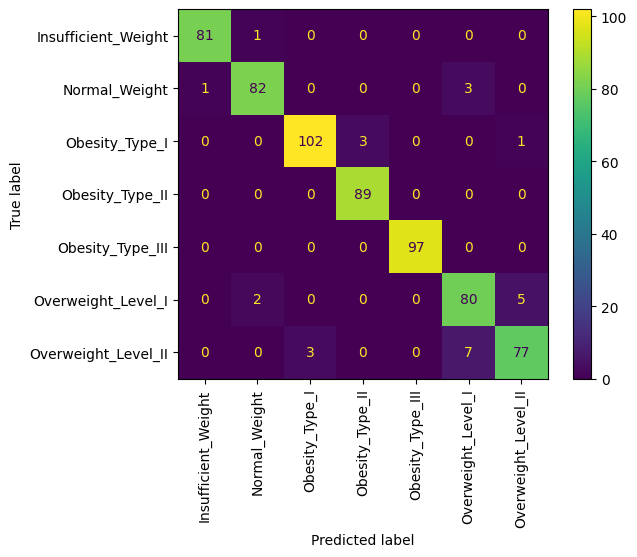

In [690]:
evaluate(clf_lr, X_train, X_test, y_train, y_test)

Wyniki są całkiem niezłe -- mamy dość wysoki F1 score, a po samej macierzy pomyłek widać, że model
popełnia niewiele błędów. Problemem może być jedynie widoczne przeuczenie modelu objawiające się
widocznie lepszymi wynikami na zbiorze treningowym.

Możemy wyplotować ważności cech w zależności od klasy korzystając z wartości współczynników
`.coef_`.

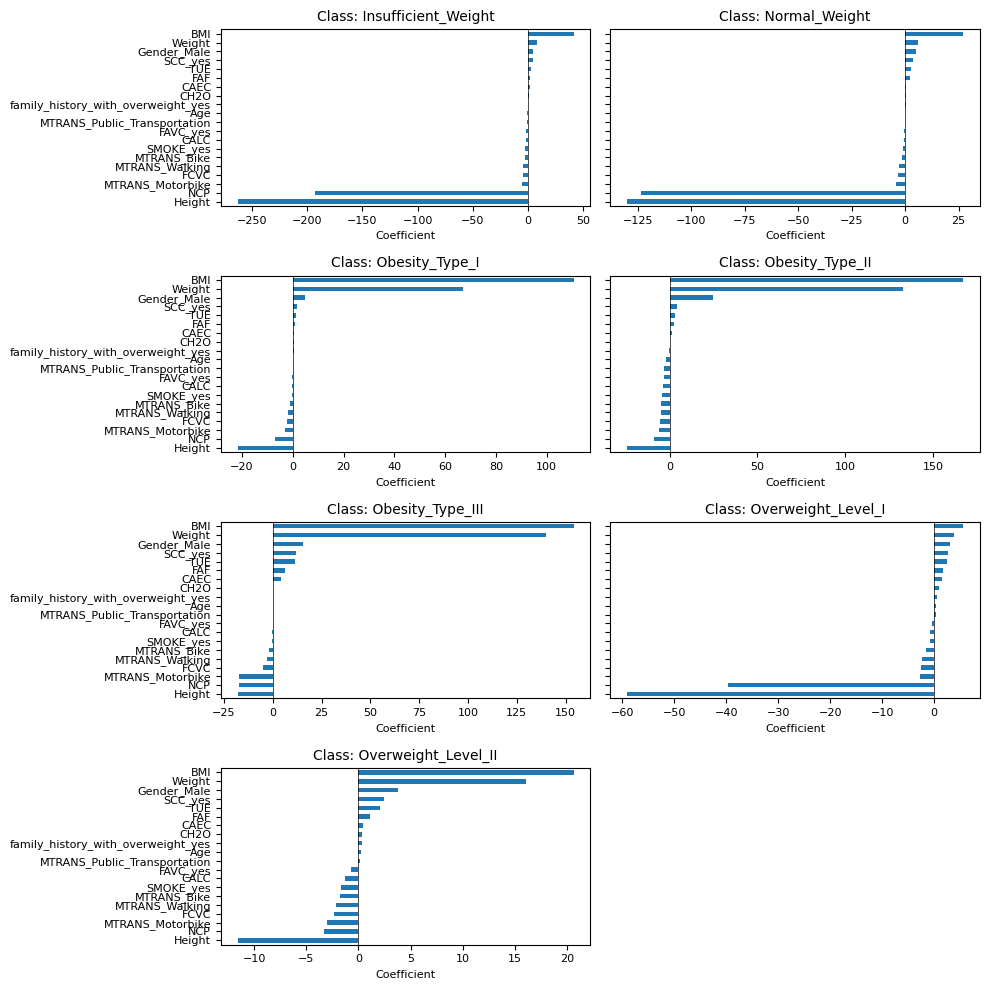

In [691]:
# ==================================================================
# Code has been generated by AI, then refined and verified manually
# ==================================================================

feature_names = clf_lr.named_steps["columntransformer"].get_feature_names_out()
coef = clf_lr.named_steps["logisticregressioncv"].coef_  # shape: (n_classes, n_features)
class_ids = clf_lr.named_steps["logisticregressioncv"].classes_  # class labels in the same order
coef_df = pd.DataFrame(coef, index=class_ids, columns=feature_names)

n_cls = coef_df.shape[0]
fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharey=True)

for ax, cls in zip(axes.flat, coef_df.index):
    # sort to show strongest positive/negative at the ends
    imp = coef_df.loc[cls].sort_values()
    imp.plot(kind="barh", ax=ax, fontsize=8)
    ax.set_title(f"Class: {cls}", fontsize=10)
    ax.axvline(0, color="black", lw=0.5)
    ax.set_xlabel("Coefficient", fontsize=8)

fig.delaxes(axes.flat[-1])

plt.tight_layout()
plt.show()

Bez niespodzianek najważniejszymi predyktorami okazały się cechy BMI, Weight, Height i Gender,
które mają największe co do wartości bezwględnej współczynniki. Możemy spróbować teraz ulepszyć
trochę baseline'owy model regresji logistycznej poprzez usunięcie nieistotnych cech i dodanie
interakcji między tymi istotnymi.

In [692]:
from sklearn.preprocessing import PolynomialFeatures

num_features_important = ["BMI", "Weight", "Height"]
cat_features_important = ["Gender"]

clf_lr_selected = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("cat_transformer", OneHotEncoder(drop="first", sparse_output=False), cat_features_important),
            ("num_transformer", MinMaxScaler(), num_features_important),
        ],
        remainder="drop",
        n_jobs=-1,
        verbose_feature_names_out=False,
    ),
    PolynomialFeatures(degree=4, interaction_only=False, include_bias=False),
    LogisticRegressionCV(Cs=100, cv=10, max_iter=10_000, n_jobs=-1, random_state=0),
)
clf_lr_selected.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('polynomialfeatures', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_transformer', ...), ('num_transformer', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


------------------------------------------------------------
Accuracy train 97.02%
Accuracy test  97.16%
------------------------------------------------------------
macro-F1 train 0.9692
macro-F1 test  0.9713
------------------------------------------------------------


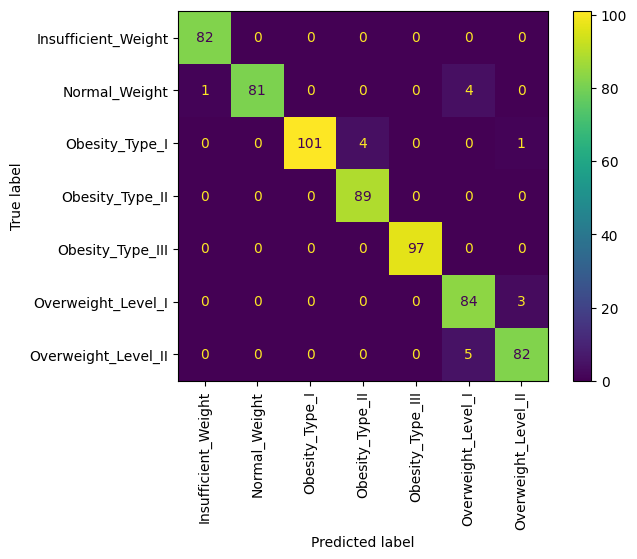

In [693]:
evaluate(clf_lr_selected, X_train, X_test, y_train, y_test)

Po usunięciu nieistotnych predyktorów i dodaniu interakcji, prosty model regresji logistycznej
działa naprawdę nieźle. Udało się pozbyć występującego wcześniej przeuczenia oraz widocznie poprawić
wartości metryk accuracy i F1 na zbiorze testowym.

### Drzewa decyzyjne

Jako drugi model, spróbujemy wykorzystać klasyczne drzewa decyzyjne. Tutaj również wykorzystamy
implementację z biblioteki Scikit-learn, która niestety posiada jedną wadę, otóż nie obsługuje
natywnie zmiennych kategorycznych, dlatego też musimy je odpowiednio zakodować w postaci one-hot.
Dodatkowo wykonamy lekki tuning hiperparametrów korzystając z `GridSearchCV` i 10-krotnej walidacji
krzyżowej.

In [694]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

clf_dt = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("cat_transformer", OneHotEncoder(drop="first", sparse_output=False), cat_features),
        ],
        remainder="passthrough",
        n_jobs=-1,
        verbose_feature_names_out=False,
    ),
    GridSearchCV(
        DecisionTreeClassifier(random_state=0),
        param_grid={
            "max_depth": [2, 3, 5, 10, 12, 14, None],
            "min_samples_leaf": [2, 3, 5, 9],
            "min_samples_split": [2, 5, 10],
        },
        cv=10,
        scoring="accuracy",
        n_jobs=-1,
    ),
)
clf_dt.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('gridsearchcv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_transformer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


------------------------------------------------------------
Accuracy train 97.56%
Accuracy test  97.63%
------------------------------------------------------------
macro-F1 train 0.9754
macro-F1 test  0.9763
------------------------------------------------------------


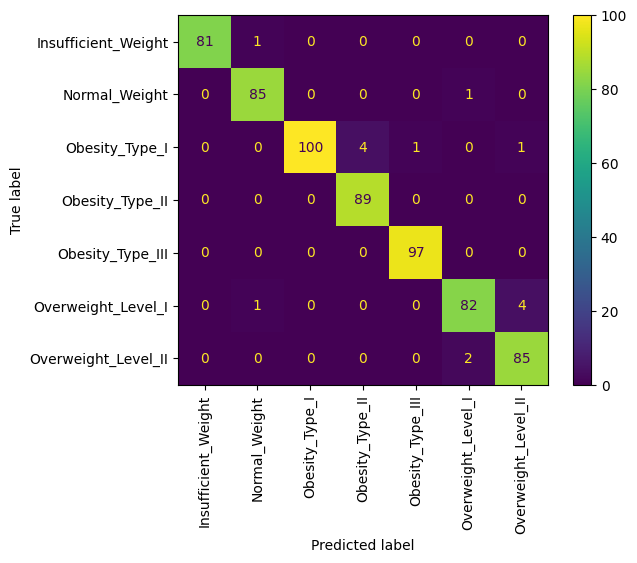

In [695]:
evaluate(clf_dt, X_train, X_test, y_train, y_test)

Tutaj wyniki są już naprawdę dobre, a dodatkowo nie występuje przeuczenie. Możemy też narysować
uzyskane drzewo, a sam model jest łatwo interpretowalny.

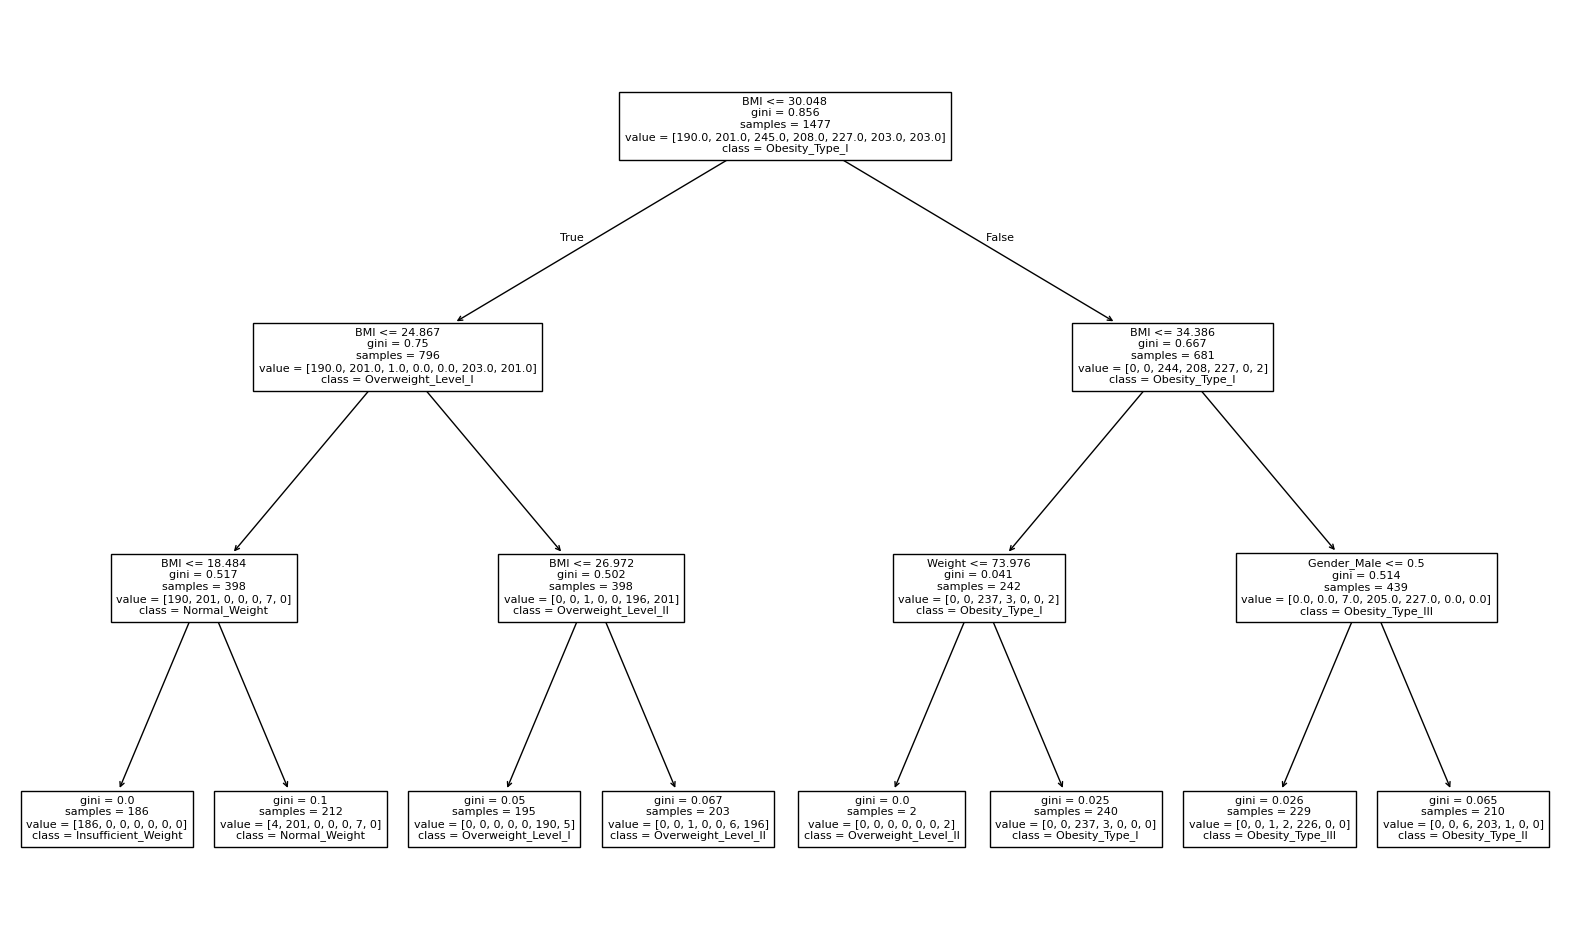

In [696]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(
    decision_tree := clf_dt.named_steps["gridsearchcv"].best_estimator_,
    ax=ax,
    fontsize=8,
    feature_names=decision_tree.feature_names_in_,
    class_names=decision_tree.classes_,
)
plt.show()

### Lasy losowe

Kolejnym modelem jest las losowy zaimplementowany w Sciki-learn jako `RandomForestClassifier`. Tutaj
stosujemy jedynie domyślne hiper-parametry, bez dodatkowego strojenia, które w przypadku lasów
losowych jest już dość kosztowne obliczeniowo. Ponownie musimy zakodować zmienne kategoryczne w
postaci one-hot, gdyż ta implementacja nie wspiera natywnie zmiennych kategorycznych.

In [697]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("cat_transformer", OneHotEncoder(drop="first", sparse_output=False), cat_features),
        ],
        remainder="passthrough",
        n_jobs=-1,
        verbose_feature_names_out=False,
    ),
    RandomForestClassifier(random_state=0),
)
clf_rf.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_transformer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


------------------------------------------------------------
Accuracy train 100.00%
Accuracy test  98.74%
------------------------------------------------------------
macro-F1 train 1.0000
macro-F1 test  0.9871
------------------------------------------------------------


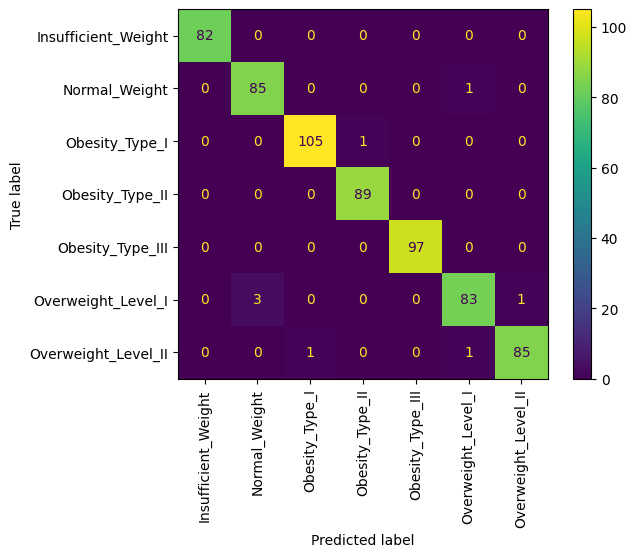

In [698]:
evaluate(clf_rf, X_train, X_test, y_train, y_test)

W tym przypadku wyniki są jeszcze lepsze -- mamy dość wysoki F1 score, wyższy niż dla regresji
logistycznej i drzew decyzyjnych. Model jednak wyraźnie przeucza. 

Implementacja lasów losowych w bibliotece Scikit-learn wspiera domyślnie ważności poszczególnych
cech, więc i w tym przypadku możemy je wyplotować.

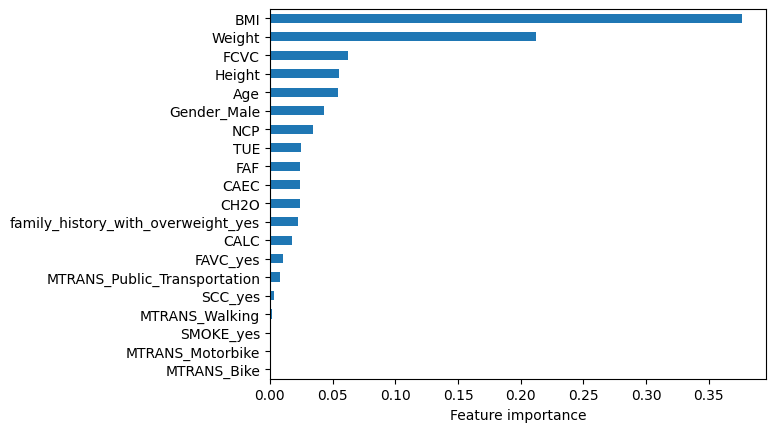

In [699]:
(
    pd.Series(
        clf_rf.named_steps["randomforestclassifier"].feature_importances_,
        clf_rf.named_steps["randomforestclassifier"].feature_names_in_,
    )
    .sort_values()
    .plot.barh(xlabel="Feature importance")
);

Bez zaskoczeń ponownie najważniejsze okazały się BMI i Weight, chociaż dość wysoko znajduje się
również zmienna FCVC, określająca ilość warzyw spożywanych w posiłkach.

### Gradient Boosted Decision Trees

Ostatnim przedstawicielem modeli drzewiastych, który wypróbujemy będzie sławny CatBoost. W tym
przypadku implementacja wspiera natywnie zmienne kategoryczne, więc nie musimy ich wcześniej
transformować.

In [700]:
from catboost import CatBoostClassifier

clf_gbdt = CatBoostClassifier(l2_leaf_reg=0.1, verbose=False, random_state=0)
clf_gbdt.fit(X_train, y_train, cat_features=cat_features.tolist())

------------------------------------------------------------
Accuracy train 100.00%
Accuracy test  99.05%
------------------------------------------------------------
macro-F1 train 1.0000
macro-F1 test  0.9903
------------------------------------------------------------


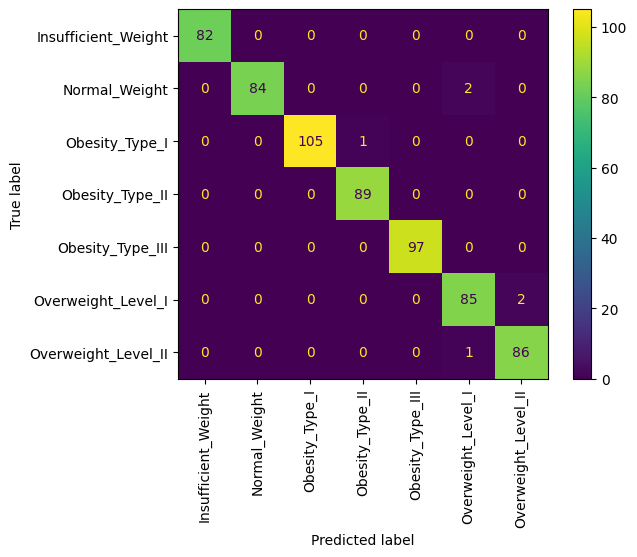

In [701]:
evaluate(clf_gbdt, X_train, X_test, y_train, y_test)

Wyniki są już niemal idealne! CatBoost uzyskuje najlepszy wynik accuracy i macro-F1 ze wszystkich
klasyfikatorów do tej pory. Niewielkim problemem jest lekkie przeuczenie, ale przy tak dobrym wyniku
właściwie nie ma na co narzekać.

Implementacja boostingu gradientowego w CatBoost wspiera domyślnie ważności poszczególnych cech,
więc i w tym przypadku możemy je wyplotować.

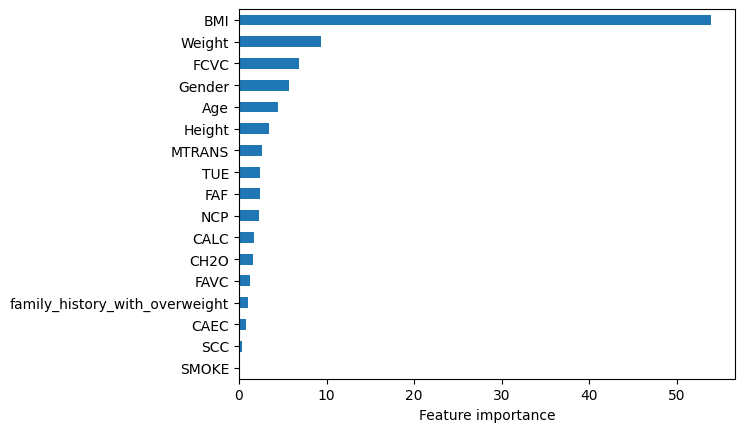

In [702]:
(
    pd.Series(clf_gbdt.feature_importances_, clf_gbdt.feature_names_)
    .sort_values()
    .plot.barh(xlabel="Feature importance")
);

Uzyskane ważności cech są praktycznie jednakowe, jak w przypadku lasu losowego.

### Regresja porządkowa

Na koniec spróbujemy wykorzystać model logitowej regresji porządkowej, traktując zmienną objaśnianą
jako zmienną porządkową. Nasze klasy mają naturalną relację porządku, co w ogóle umożliwia użycie
tego modelu statystycznego. Najpierw musimy wykonać transformację zmiennej NObeyesdad z
`categorical` na `ordered categorical`. 

In [703]:
ordered_classes = np.array(
    [
        "Insufficient_Weight",
        "Normal_Weight",
        "Overweight_Level_I",
        "Overweight_Level_II",
        "Obesity_Type_I",
        "Obesity_Type_II",
        "Obesity_Type_III",
    ]
)

df_train = pd.concat([X_train, y_train], axis="columns")
df_test = pd.concat([X_test, y_test], axis="columns")

df_train["NObeyesdad"] = pd.Categorical(df_train["NObeyesdad"], categories=ordered_classes, ordered=True)
df_test["NObeyesdad"] = pd.Categorical(df_test["NObeyesdad"], categories=ordered_classes, ordered=True)

Dodajemy również explicite kodowania zmiennych kategorycznych w postaci one-hot i przeskalowujemy
odpowiednio zmienne numeryczne do ttego samego zakresu wartości.

In [704]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_transformer", OneHotEncoder(drop="first", sparse_output=False), cat_features),
        ("num_transformer", MinMaxScaler(), num_features),
    ],
    remainder="passthrough",
    n_jobs=-1,
    verbose_feature_names_out=False,
)

df_train_preprocessed = preprocessor.fit_transform(df_train)
df_test_preprocessed = preprocessor.transform(df_test)

Skorzystamy z biblioteki statsmodels i dostępnej w niej implementacji regresji porządkowej.
Wykorzystamy również R-owy sposób opisu modelu i wprowadzimy pewne interakcje między cechami oparte
o to co widzieliśmy już dla wcześniejszych modeli.

In [705]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

mod_ord = OrderedModel.from_formula(
    "NObeyesdad ~ 0 + BMI*Age*Gender_Male + BMI*Height*Weight + Gender_Male*Height*Weight",
    data=df_train_preprocessed,
    distr="logit",
)
fit_ord = mod_ord.fit(method="lbfgs", maxiter=10_000)
fit_ord.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:             NObeyesdad   Log-Likelihood:                -165.29
Model:                   OrderedModel   AIC:                             374.6
Method:            Maximum Likelihood   BIC:                             491.1
Date:                Mon, 09 Jun 2025                                         
Time:                        01:01:54                                         
No. Observations:                1477                                         
Df Residuals:                    1455                                         
Df Model:                          16                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
BMI                                      209.5766   1348.335      0.155      0.876   -2433.112    2852.265
Age                                       -9.7323      7.363     -1.322      0.186     -24.164       4.700
BMI:Age                                   18.1412     17.462      1.039      0.299     -16.084      52.366
Gender_Male                               -8.3012     16.098     -0.516      0.606     -39.852      23.250
BMI:Gender_Male                           31.8325    108.234      0.294      0.769    -180.303     243.968
Age:Gender_Male                            9.7349      9.341      1.042      0.297      -8.573      28.043
BMI:Age:Gender_Male                      -13.4491     21.588     -0.623      0.533     -55.761      28.863
Height                                   -48.5426    350.429     -0.139      0.890    -735.370     638.285
BMI:Height                                84.6973    714.481      0.119      0.906   -1315.659    1485.054
Weight                                   134.7033   2355.912      0.057      0.954   -4482.800    4752.207
BMI:Weight                              -300.0974     53.720     -5.586      0.000    -405.386    -194.809
Height:Weight                             -4.4119    332.368     -0.013      0.989    -655.841     647.017
BMI:Height:Weight                        128.4400     42.589      3.016      0.003      44.967     211.913
Gender_Male:Height                        29.6090     27.858      1.063      0.288     -24.991      84.209
Gender_Male:Weight                       -52.2359    172.904     -0.302      0.763    -391.122     286.650
Gender_Male:Height:Weight                -46.7287     73.076     -0.639      0.523    -189.954      96.497
Insufficient_Weight/Normal_Weight         26.6584    205.523      0.130      0.897    -376.159     429.476
Normal_Weight/Overweight_Level_I           3.7506      0.091     41.206      0.000       3.572       3.929
Overweight_Level_I/Overweight_Level_II     2.5739      0.085     30.394      0.000       2.408       2.740
Overweight_Level_II/Obesity_Type_I         2.7672      0.079     34.953      0.000       2.612       2.922
Obesity_Type_I/Obesity_Type_II             2.8296      0.088     32.150      0.000       2.657       3.002
Obesity_Type_II/Obesity_Type_III           2.6269      0.116     22.731      0.000       2.400       2.853
==========================================================================================================
"""

In [715]:
y_pred_ord_test = ordered_classes[fit_ord.predict(df_test_preprocessed).idxmax(1)]
y_pred_ord_train = ordered_classes[fit_ord.predict(df_train_preprocessed).idxmax(1)]

print(f"Train accuracy {accuracy_score(y_train, y_pred_ord_train):.2%}")
print(f"Test  accuracy {accuracy_score(y_test, y_pred_ord_test):.2%}")
print(f"Train macro-F1 {f1_score(y_train, y_pred_ord_train, average='macro'):.4f}")
print(f"Test  macro-F1 {f1_score(y_test, y_pred_ord_test, average='macro'):.4f}")

Train accuracy 96.75%
Test  accuracy 97.48%
Train macro-F1 0.9665
Test  macro-F1 0.9741


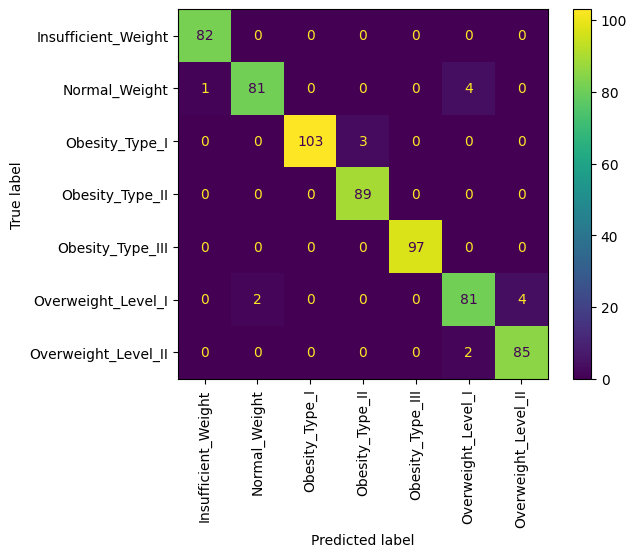

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_ord_test,
    xticks_rotation="vertical",
)
plt.show()

Uzyskane wyniki są porównywalne z tymi dla drzewa decyzyjnego, ale jednak model nie jest tak łatwo
intepretowalny jak drzewo. Na pewno jest to jednak dobra alternatywa dla wieloklasowej regresji
logistycznej.

### Porównanie modeli

Modele porównamy korzystając z wykorzystywanych cały czas metryk -- accuracy i macro-F1. Ponieważ
nasz dataset jest zbalansowany, więc tak naprawdę metryka accuracy daje wystarczająco dużo
informacji, ale macro-F1 jest jej dobrym uzupełnieniem.

In [720]:
accuracy_scores = {
    "Logistic Regression": accuracy_score(y_test, clf_lr.predict(X_test)),
    "Logistic Regression with selected features": accuracy_score(y_test, clf_lr_selected.predict(X_test)),
    "Decision Tree": accuracy_score(y_test, clf_dt.predict(X_test)),
    "Random Forest": accuracy_score(y_test, clf_rf.predict(X_test)),
    "GBDT": accuracy_score(y_test, clf_gbdt.predict(X_test)),
    "Ordinal Regression": accuracy_score(y_test, y_pred_ord_test),
}

f1_scores = {
    "Logistic Regression": f1_score(y_test, clf_lr.predict(X_test), average="macro"),
    "Logistic Regression with selected features": f1_score(y_test, clf_lr_selected.predict(X_test), average="macro"),
    "Decision Tree": f1_score(y_test, clf_dt.predict(X_test), average="macro"),
    "Random Forest": f1_score(y_test, clf_rf.predict(X_test), average="macro"),
    "GBDT": f1_score(y_test, clf_gbdt.predict(X_test), average="macro"),
    "Ordinal Regression": f1_score(y_test, y_pred_ord_test, average="macro"),
}

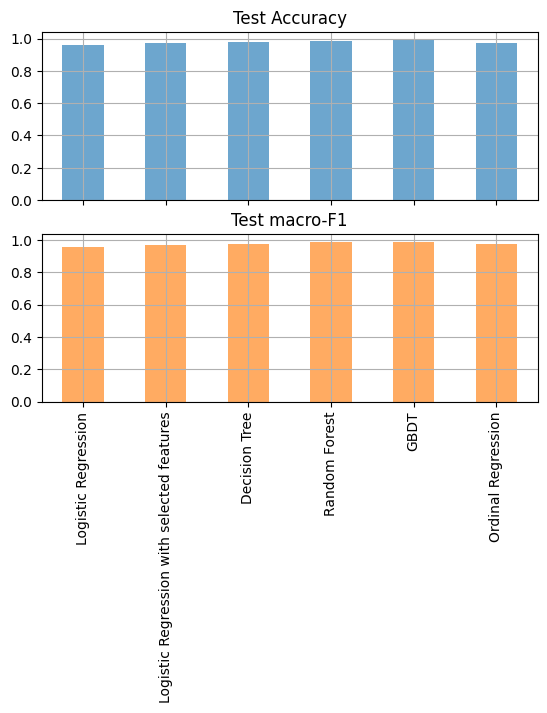

In [730]:
(
    pd.DataFrame({"Test Accuracy": accuracy_scores, "Test macro-F1": f1_scores}).plot.bar(
        subplots=True,
        alpha=0.65,
        grid=True,
        legend=False,
    )
);

Wszystkie modele osiągają bardzo zbliżone wyniki dokładności w zakresie 0.95–1.00. Random Forest i
GBDT osiągają minimalnie wyższą dokładność, choć różnice są bardzo małe. Nawet prosta regresja
logistyczna z wybranymi cechami radzi sobie równie dobrze jak bardziej złożone modele. Analogicznie
jest w przypadku F1. Wszystkie modele osiągają bardzo wysokie wartości bliskie 1.0. 

### Podsumowanie

Wszystkie analizowane modele dobrze nadają się do problemu klasyfikacji poziomu otyłości, co
potwierdzają wysokie wartości dokładności i macro-F1, zarówno dla modeli prostych, jak i złożonych.
Modele bardziej złożone (GBDT, Random Forest) nie mają znaczącej przewagi nad prostszymi modelami,
co sugeruje, że dane są dobrze ustrukturyzowane i łatwe do klasyfikacji. Ordinal Regression radzi
sobie równie dobrze, co jest spójne z tym, że klasy mają naturalny porządek. To czyni ten model
interpretowalnym i uzasadnionym statystycznie wyborem. Oprócz niego bardzo łatwo interpretowalnym i
dobrze radzącym sobie modelem jest drzewo decyzyjne, które jest być może najlepszym wyborem dla tego
datasetu łącząc dobre wyniki i prostotę. Modele ensemblowe (GBDT, Random Forest) osiągają najwyższą
skuteczność i są najlepszym wyborem, gdy kluczowe jest maksymalne dopasowanie. Modele
interpretowalne (Ordinal Regression, Decision Tree) są bardziej transparentne i polecane, jeśli
celem jest zrozumienie zależności lub wdrożenie w kontekście medycznym.
